<a href="https://colab.research.google.com/github/sambhavpurohit14/Smart_Gallery/blob/fine-tuning/TREC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT for classification : with and without fine-tuning


In [1]:
'''
get pretrained BERT
get TREC dataset
add classification head without fine tune
use Trainer on pretrained BERT base to fine tune it
test before vs after
'''

'\nget pretrained BERT\nget TREC dataset\nadd classification head without fine tune\nuse Trainer on pretrained BERT base to fine tune it\ntest before vs after\n'

In [2]:
# pretrained model
from transformers import BertModel, BertTokenizer

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

trec.py:   0%|          | 0.00/5.09k [00:00<?, ?B/s]

The repository for trec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/trec.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Training samples: 5452
Test samples: 500
                                                text  coarse_label  fine_label
0  How did serfdom develop in and then leave Russ...             2          26
1   What films featured the character Popeye Doyle ?             1           5
2  How can I find a list of celebrities ' real na...             2          26
3  What fowl grabs the spotlight after the Chines...             1           2
4                    What is the full form of .com ?             0           1

Class distribution (Coarse Labels):
coarse_label
1    1250
3    1223
2    1162
5     896
4     835
0      86
Name: count, dtype: int64


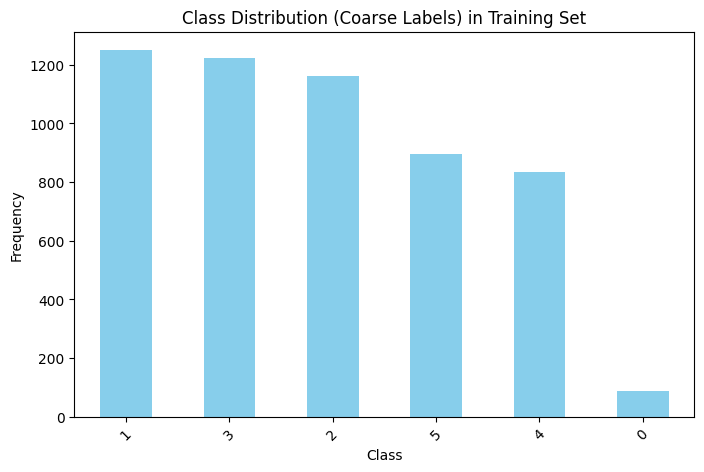

In [4]:
from datasets import load_dataset
import pandas as pd

# load the TREC dataset
dataset = load_dataset('trec')

train_data = dataset['train']
test_data = dataset['test']

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

print(train_df.head())

# we will be using coarse labels : 6 classes
class_distribution = train_df['coarse_label'].value_counts()
print("\nClass distribution (Coarse Labels):")
print(class_distribution)


# Plot the distribution of coarse labels
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution (Coarse Labels) in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
# class zero is relatively undersampled, we'll use a weighted sampler

In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import WeightedRandomSampler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# dataset class
class TrecDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)  # 6 coarse labels

# text : coarse label : fine label
texts = [item['text'] for item in train_data]
coarse_labels = [item['coarse_label'] for item in train_data]

texts_test = [item['text'] for item in test_data]
coarse_labels_test = [item['coarse_label'] for item in test_data]

# Tokenize the data
encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
encodings_test = tokenizer(texts_test, truncation=True, padding=True, max_length=128)


train = TrecDataset(encodings, coarse_labels)
test = TrecDataset(encodings_test, coarse_labels_test)

# Calculate class weights for imbalance handling
label_counts = np.bincount(coarse_labels)
class_weights = compute_class_weight('balanced', classes=np.unique(coarse_labels), y=coarse_labels)
sample_weights = [class_weights[label] for label in coarse_labels]

# Define the sampler for oversampling
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train, batch_size=16, sampler=sampler)
test_loader = DataLoader(test, batch_size=16)

# pretrained bert here includes a classification headwhich classifies CLS tokens to the number of classes.
# Training loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.eval()
correct = 0
total = 0
with torch.no_grad(): # no weight update during validation
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Training Accuracy: {correct / total}")

Training Accuracy: 0.21


In [7]:
# fine tuning : you can specify if all weights can be trainable / what to freeze / what to train

from transformers import Trainer, TrainingArguments

import os
os.environ["WANDB_DISABLED"] = "true"

# configure training process
# freeze or choose params to train
for name, param in model.named_parameters():
    if "encoder.layer" in name:
        # Extract layer number correctly using regex
        import re
        match = re.search(r"encoder\.layer\.(\d+)", name)
        if match:
            layer_number = int(match.group(1))
            if layer_number < 6:  # Freeze the first 6 layers
                param.requires_grad = False

training_args = TrainingArguments(
        output_dir='./dot',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        save_steps=10_000,
        save_total_limit=2,
        evaluation_strategy="epoch",
        logging_dir='./logs',
    )
# pass the processed data, the one with input ids and encodings
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train,
    eval_dataset = test
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,No log,0.189501
2,0.358400,0.179658
3,0.074600,0.156035


TrainOutput(global_step=1023, training_loss=0.21205483063807817, metrics={'train_runtime': 121.5083, 'train_samples_per_second': 134.608, 'train_steps_per_second': 8.419, 'total_flos': 344624136832656.0, 'train_loss': 0.21205483063807817, 'epoch': 3.0})

In [8]:
model.eval()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"Training Accuracy: {correct / total}")




Training Accuracy: 0.974


In [9]:
# verify fine tuned parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.LayerNor

In [10]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")

Trainable Parameters: 66959622
